In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku

In [4]:
# using an api to get the data
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
text = open('/tmp/sonnets.txt').read().splitlines()

--2020-04-30 04:40:28--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-04-30 04:40:28 (154 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



### Tokenizing Text Data

In [0]:
tokenizer=Tokenizer()

In [0]:
tokenizer.fit_on_texts(text)

In [7]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

3211

### Creating Sequence and Padding Text 


In [0]:
input_sequence=[]
for i in text:
  sequence=tokenizer.texts_to_sequences([i])[0]
  for j in range(1,len(sequence)):
    ngrams=sequence[:j+1]
    input_sequence.append(ngrams)

In [9]:
max_len=0
for i in input_sequence:
  x=len(i)
  if x>max_len:
    max_len=x
max_len

11

In [10]:
input_sequence=pad_sequences(input_sequence,maxlen=max_len)
input_sequence

array([[   0,    0,    0, ...,    0,   34,  417],
       [   0,    0,    0, ...,   34,  417,  877],
       [   0,    0,    0, ...,  417,  877,  166],
       ...,
       [   0,    0,    0, ...,  493,  493, 3210],
       [   0,    0,    0, ...,  493, 3210,   15],
       [   0,    0,    0, ..., 3210,   15,   14]], dtype=int32)

### Creating Predictors and Labels

In [11]:
predictors=input_sequence[:,:-1]
predictors

array([[   0,    0,    0, ...,    0,    0,   34],
       [   0,    0,    0, ...,    0,   34,  417],
       [   0,    0,    0, ...,   34,  417,  877],
       ...,
       [   0,    0,    0, ..., 3209,  493,  493],
       [   0,    0,    0, ...,  493,  493, 3210],
       [   0,    0,    0, ...,  493, 3210,   15]], dtype=int32)

In [12]:
labels=input_sequence[:,-1]
labels

array([ 417,  877,  166, ..., 3210,   15,   14], dtype=int32)

### Creating Encoding for Classes


In [0]:
labels=ku.to_categorical(labels,num_classes=vocab_size)

In [14]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Building Models

#### Multilayer Bidirectional LSTM

In [0]:
model=Sequential()

In [0]:
model.add(Embedding(vocab_size,100,input_length=max_len-1))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(vocab_size,activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
dropout (Dropout)            (None, 10, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 256)           234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 3211)              825227    
Total params: 1,775,063
Trainable params: 1,775,063
Non-trainable params: 0
______________________________________________

In [0]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
history=model.fit(predictors,labels,epochs=130)

Epoch 1/130
484/484 [==============================] - 5s 11ms/step - loss: 6.8688 - accuracy: 0.0231
Epoch 2/130
484/484 [==============================] - 5s 11ms/step - loss: 6.4749 - accuracy: 0.0265
Epoch 3/130
484/484 [==============================] - 6s 11ms/step - loss: 6.3457 - accuracy: 0.0346
Epoch 4/130
484/484 [==============================] - 6s 11ms/step - loss: 6.2257 - accuracy: 0.0368
Epoch 5/130
484/484 [==============================] - 5s 11ms/step - loss: 6.1136 - accuracy: 0.0403
Epoch 6/130
484/484 [==============================] - 5s 11ms/step - loss: 5.9896 - accuracy: 0.0489
Epoch 7/130
484/484 [==============================] - 5s 11ms/step - loss: 5.8547 - accuracy: 0.0554
Epoch 8/130
484/484 [==============================] - 5s 11ms/step - loss: 5.7298 - accuracy: 0.0620
Epoch 9/130
484/484 [==============================] - 5s 11ms/step - loss: 5.5976 - accuracy: 0.0660
Epoch 10/130
484/484 [==============================] - 5s 11ms/step - loss: 5.465

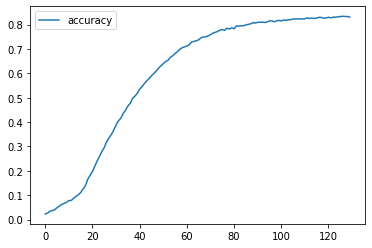

In [20]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.legend()
plt.show()

#### Model has a accuracy of 83 %

### Predicting new poem

In [0]:
new_text="Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

In [33]:
for i in range(next_words):
  tokens=tokenizer.texts_to_sequences([new_text])
  padded_sequence=pad_sequences(tokens,maxlen=max_len-1)
  prediction=model.predict_classes(padded_sequence)
  
  for word,index in tokenizer.word_index.items():
    if index == prediction:
      output_word = word
      break
  new_text = new_text+' ' + output_word
print(new_text)

Help me Obi Wan Kenobi, you're my only hope to the brain that end to this face me live assured thee more ' ' this ' art be bold remains thou dost spend so free you ' thee not not your out ' ' my gain of me ' to me fair ' have no tongue ' see it in you to me strange rotten less upon ' bail eye's ' ' ' ' not me bold thee be say as me long thee whose rare ' ' ' ' thee come thy heart forbear more be die more rare torn old eyes in her hate ' are heart
